In [1]:
from IPython import get_ipython


 # Self-Driving Car Engineer Nanodegree


 ## Project: **Finding Lane Lines on the Road**
 ***
 In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below.

 Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

 In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

 ---
 Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

 **Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

 ---

 **The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

 ---

 <figure>
  <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
  <figcaption>
  <p></p>
  <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p>
  </figcaption>
 </figure>
  <p></p>
 <figure>
  <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
  <figcaption>
  <p></p>
  <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p>
  </figcaption>
 </figure>

 **Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**

 ## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
get_ipython().run_line_magic('matplotlib', 'inline')


 ## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


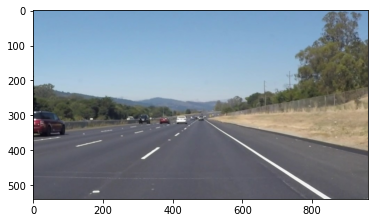

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')


 ## Ideas for Lane Detection Pipeline

 **Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

 `cv2.inRange()` for color selection
 `cv2.fillPoly()` for regions selection
 `cv2.line()` to draw lines on an image given endpoints
 `cv2.addWeighted()` to coadd / overlay two images
 `cv2.cvtColor()` to grayscale or change color
 `cv2.imwrite()` to output images to file
 `cv2.bitwise_and()` to apply a mask to an image

 **Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

 ## Helper Functions

 Below are some helper functions to help get you started. They should look familiar from the lesson!

 // TODO Adjust Gaussian blur based on image resolution.

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    # TODO extract the generation of the mask since no need to regenerate for every image
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    # The first 2 dimensions are the x and y axis of the picture,
    # the third dimension holds an array of colors (RGB) if there's more than one channel of color.
    if len(img.shape) > 2:  
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines_orig(img, lines, region_of_interest_vertices, color=[255, 0, 0], thickness_final_lines=5, thickness_input_lines=2):
    # Compute m & b in y = m*x+b formula of all lines
    # Separate left and right lines
    # Take average of m and b (--> 2 average vectors of all left and right vectors in Hough space)
    # Compute x for y=<bottom of image> and x for y=<top of image>
    # Trace line between those 2 points
    avg_m_left, avg_m_right = 0.0, 0.0
    avg_b_left, avg_b_right = 0.0, 0.0
    left_count, right_count = 0, 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x2 == x1:
                continue  # Avoid messing up average with vertical lines
            m = (y2-y1)/(x2-x1)
            b = y1 - m * x1
            if m >= 0:
                avg_m_left += m
                avg_b_left += b
                left_count += 1
            else:
                avg_m_right += m
                avg_b_right += b
                right_count += 1
            # Add line to resulting image to help understand why we get the final lines
            cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], thickness_input_lines)

    # Left
    # x = (y - b)/m
    if left_count > 0:
        avg_m_left /= left_count
        avg_b_left /= left_count
        if avg_m_left != 0:
            x_left_bottom = int((img.shape[0] - avg_b_left) / avg_m_left)
            x_left_top = int(-avg_b_left / avg_m_left)
        else:
            x_left_bottom = 0
            x_left_top = img.shape[1]
        cv2.line(img, (x_left_bottom, img.shape[0]), (x_left_top, 0), color, thickness_final_lines)

    # Right
    if right_count > 0:
        avg_m_right /= right_count
        avg_b_right /= right_count
        if avg_m_right != 0:
            x_right_bottom = int((img.shape[0] - avg_b_right) / avg_m_right)
            x_right_top = int(-avg_b_right / avg_m_right)
        else:
            x_right_bottom = img.shape[1]
            x_right_top = 0
        cv2.line(img, (x_right_bottom, img.shape[0]), (x_right_top, 0), color, thickness_final_lines)

    return region_of_interest(img, region_of_interest_vertices)

def draw_lines_polar(img, lines, region_of_interest_vertices, color=[255, 0, 0], thickness_final_lines=5, thickness_input_lines=2):
    # Compute theta & rho for all lines
    # Keep angle in range ]0;180] since line(angle) == line(angle+180°)
    # Separate left and right lines
    # Take average of theta & rho (--> 2 average vectors of all left and right vectors in Hough space)
    # Compute x for y="bottom of image" and x for y="<"top of image"
    # Trace line between those 2 points
    avg_theta_left, avg_theta_right = 0.0, 0.0
    avg_rho_left, avg_rho_right = 0.0, 0.0
    left_count, right_count = 0, 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Convert to polar coordinates
            theta = math.atan2(y2-y1, x2-x1)
            if theta <= 0:
                theta += math.pi  # Keep angle in range ]0;180] since line(angle) == line(angle+180°)

            rho = abs((x2-x1)*y1-x1*(y2-y1)) / math.sqrt(math.pow(x2-x1, 2) + math.pow(y2-y1, 2))

            if theta >= math.pi/2:
                avg_theta_left += theta
                avg_rho_left += rho
                left_count += 1
            else:
                avg_theta_right += theta
                avg_rho_right += rho
                right_count += 1
            # Add line to resulting image to help understand why we get the final lines
            cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], thickness_input_lines)

    # Left
    # x = (y - b)/m
    if left_count > 0:
        avg_theta_left /= left_count
        avg_rho_left /= left_count
        x_left_bottom = int((avg_rho_left - img.shape[0] * math.sin(avg_theta_left)) / math.cos(avg_theta_left))
        x_left_top = int(avg_rho_left / math.cos(avg_theta_left))
        print((x_left_bottom, img.shape[0]), (x_left_top, 0))

        cv2.line(img, (x_left_bottom, img.shape[0]), (x_left_top, 0), color, thickness_final_lines)

    # Right
    if right_count > 0:
        avg_theta_right /= right_count
        avg_rho_right /= right_count
        x_right_bottom = int((avg_rho_right - img.shape[0] * math.sin(avg_theta_right)) / math.cos(avg_theta_right))
        x_right_top = int(avg_rho_right / math.cos(avg_theta_right))
        print((x_right_bottom, img.shape[0]), (x_right_top, 0))

        cv2.line(img, (x_right_bottom, img.shape[0]), (x_right_top, 0), color, thickness_final_lines)

    return img #region_of_interest(img, region_of_interest_vertices)

def draw_lines(img, lines, region_of_interest_vertices, color=[255, 0, 0], thickness_final_lines=5, thickness_input_lines=2, plot_hough_heatmap=False):
    # Compute m & b in x = m*y+b formula of all lines
    # Separate left and right lines
    # Take average of m and b (--> 2 weighted average vectors of all left and right vectors in Hough space)
    # I use the norm of the each vector as weight to compute the weighted average.
    # With the averages, compute x for y="height of image" and x for y="top of image"
    # Trace line between those 2 points
    
    if lines is None:
        return img

    avg_m_left, avg_m_right = 0.0, 0.0
    avg_b_left, avg_b_right = 0.0, 0.0
    norm_sum_left, norm_sum_right = 0.0, 0.0

    if plot_hough_heatmap:
        hough_heatmap_left = np.zeros((40, 90))
        hough_heatmap_right = np.zeros((40, 90))

    for line in lines:
        for x1,y1,x2,y2 in line:
            if y1 == y2:
                continue  # Avoid lines parallel to horizon
            current_vector = np.array([x2-x1, y2-y1])
            # Find point on bottom of image (reversing x and y):
            m = (x2-x1)/(y2-y1)
            b = x1 - m * y1

            # Compute norm
            norm = np.sqrt(current_vector.dot(current_vector))
            print(int(x1), int(y1), int(x2), int(y2), int(m), int(b), int(norm))

            if m < 0:
                avg_m_left += m * norm
                avg_b_left += b * norm
                norm_sum_left += norm
                if plot_hough_heatmap:
                    hough_heatmap_left[int(20+math.copysign(math.log2(abs(b)), b)), int(abs(math.atan(m)*180/math.pi))] += norm
            else:
                avg_m_right += m * norm
                avg_b_right += b * norm
                norm_sum_right += norm
                if plot_hough_heatmap:
                    hough_heatmap_right[int(20+math.copysign(math.log2(abs(b)), b)), int(abs(math.atan(m)*180/math.pi))] += norm
            # Add line to resulting image to help understand why we get the final lines
            cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], thickness_input_lines)

    # Left
    if norm_sum_left > 0:
        avg_m_left /= norm_sum_left
        avg_b_left /= norm_sum_left
        x_left_bottom = int(avg_m_left * img.shape[0] + avg_b_left)
        cv2.line(img, (x_left_bottom, img.shape[0]), (int(avg_b_left), 0), color, thickness_final_lines)

    # Right
    if norm_sum_right > 0:
        avg_m_right /= norm_sum_right
        avg_b_right /= norm_sum_right
        x_right_bottom = int(avg_m_right * img.shape[0] + avg_b_right)
        cv2.line(img, (x_right_bottom, img.shape[0]), (int(avg_b_right), 0), color, thickness_final_lines)

    if plot_hough_heatmap:
        plt.subplot(527).imshow(hough_heatmap_left, cmap='hot', interpolation='nearest')
        plt.subplot(527).set_title('Left line Hough heatmap', fontsize=20)
        plt.subplot(528).imshow(hough_heatmap_right, cmap='hot', interpolation='nearest')
        plt.subplot(528).set_title('Right line Hough heatmap', fontsize=20)
    
    return region_of_interest(img, region_of_interest_vertices)

def draw_lines_median(img, lines, region_of_interest_vertices, color=[255, 0, 0], thickness_final_lines=5, thickness_input_lines=2, plot_hough_heatmap=False):
    # Compute m & b in x = m*y+b formula of all lines
    # Separate left and right lines
    # Take median of m and b (--> 2 weighted average vectors of all left and right vectors in Hough space)
    # With the median, compute x for y="height of image" and x for y="top of image"
    # Trace line between those 2 points
    
    if lines is None:
        return img
    
    array_left = []
    array_right = []

    if plot_hough_heatmap:
        hough_heatmap_left = np.zeros((40, 90))
        hough_heatmap_right = np.zeros((40, 90))

    for line in lines:
        for x1,y1,x2,y2 in line:
            if y1 == y2:
                continue  # Avoid lines parallel to horizon
            current_vector = np.array([x2-x1, y2-y1])
            # Find point on bottom of image (reversing x and y):
            m = (x2-x1)/(y2-y1)
            b = x1 - m * y1

            # Compute norm
            norm = np.sqrt(current_vector.dot(current_vector))

            if m < 0:
                array_left.append([m, b])
                if plot_hough_heatmap:
                    hough_heatmap_left[int(20+math.copysign(math.log2(abs(b)), b)), int(abs(math.atan(m)*180/math.pi))] += norm
            else:
                array_right.append([m, b])
                if plot_hough_heatmap:
                    hough_heatmap_right[int(20+math.copysign(math.log2(abs(b)), b)), int(abs(math.atan(m)*180/math.pi))] += norm
            # Add line to resulting image to help understand why we get the final lines
            cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], thickness_input_lines)

    # Left
    if len(array_left) > 0:
        median_m_left, median_b_left = np.median(array_left, axis=0)
        x_left_bottom = int(median_m_left * img.shape[0] + median_b_left)
        cv2.line(img, (x_left_bottom, img.shape[0]), (int(median_b_left), 0), color, thickness_final_lines)

    # Right
    if len(array_right) > 0:
        median_m_right, median_b_right = np.median(array_right, axis=0)
        x_right_bottom = int(median_m_right * img.shape[0] + median_b_right)
        cv2.line(img, (x_right_bottom, img.shape[0]), (int(median_b_right), 0), color, thickness_final_lines)

    if plot_hough_heatmap:
        plt.subplot(527).imshow(hough_heatmap_left, cmap='hot', interpolation='nearest')
        plt.subplot(527).set_title('Left line Hough heatmap', fontsize=20)
        plt.subplot(528).imshow(hough_heatmap_right, cmap='hot', interpolation='nearest')
        plt.subplot(528).set_title('Right line Hough heatmap', fontsize=20)
    
    return region_of_interest(img, region_of_interest_vertices)
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, region_of_interest_vertices, plot_hough_heatmap=False):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    return draw_lines_median(line_img, lines, region_of_interest_vertices, plot_hough_heatmap=plot_hough_heatmap)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


 ## Test Images

 Build your pipeline to work on the images in the directory "test_images"
 **You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")


['vlcsnap-2021-02-28-20h28m23s569.jpg',
 'vlcsnap-2021-03-14-17h14m02s670.jpg',
 '.DS_Store',
 'solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'vlcsnap-2021-03-21-18h30m22s331.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

 ## Build a Lane Finding Pipeline



 ### Test pipeline on one image
 I added this section to accelerate the initial tuning of the parameters by focusing on one image.
 The same values of parameters will be used for the rest of the images and videos.

 I wanted to get a view of all the intermediate steps of the pipeline to quickly see the effect of each change in my parameters.

 I had to tune the mask vertices to cut out the noise generated by the landscape on the side of the road.

/usr/local/Caskroom/miniconda/base/envs/carnd-term1/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/Caskroom/miniconda/base/envs/carnd-term1/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/Caskroom/miniconda/base/envs/carnd-term1/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarni

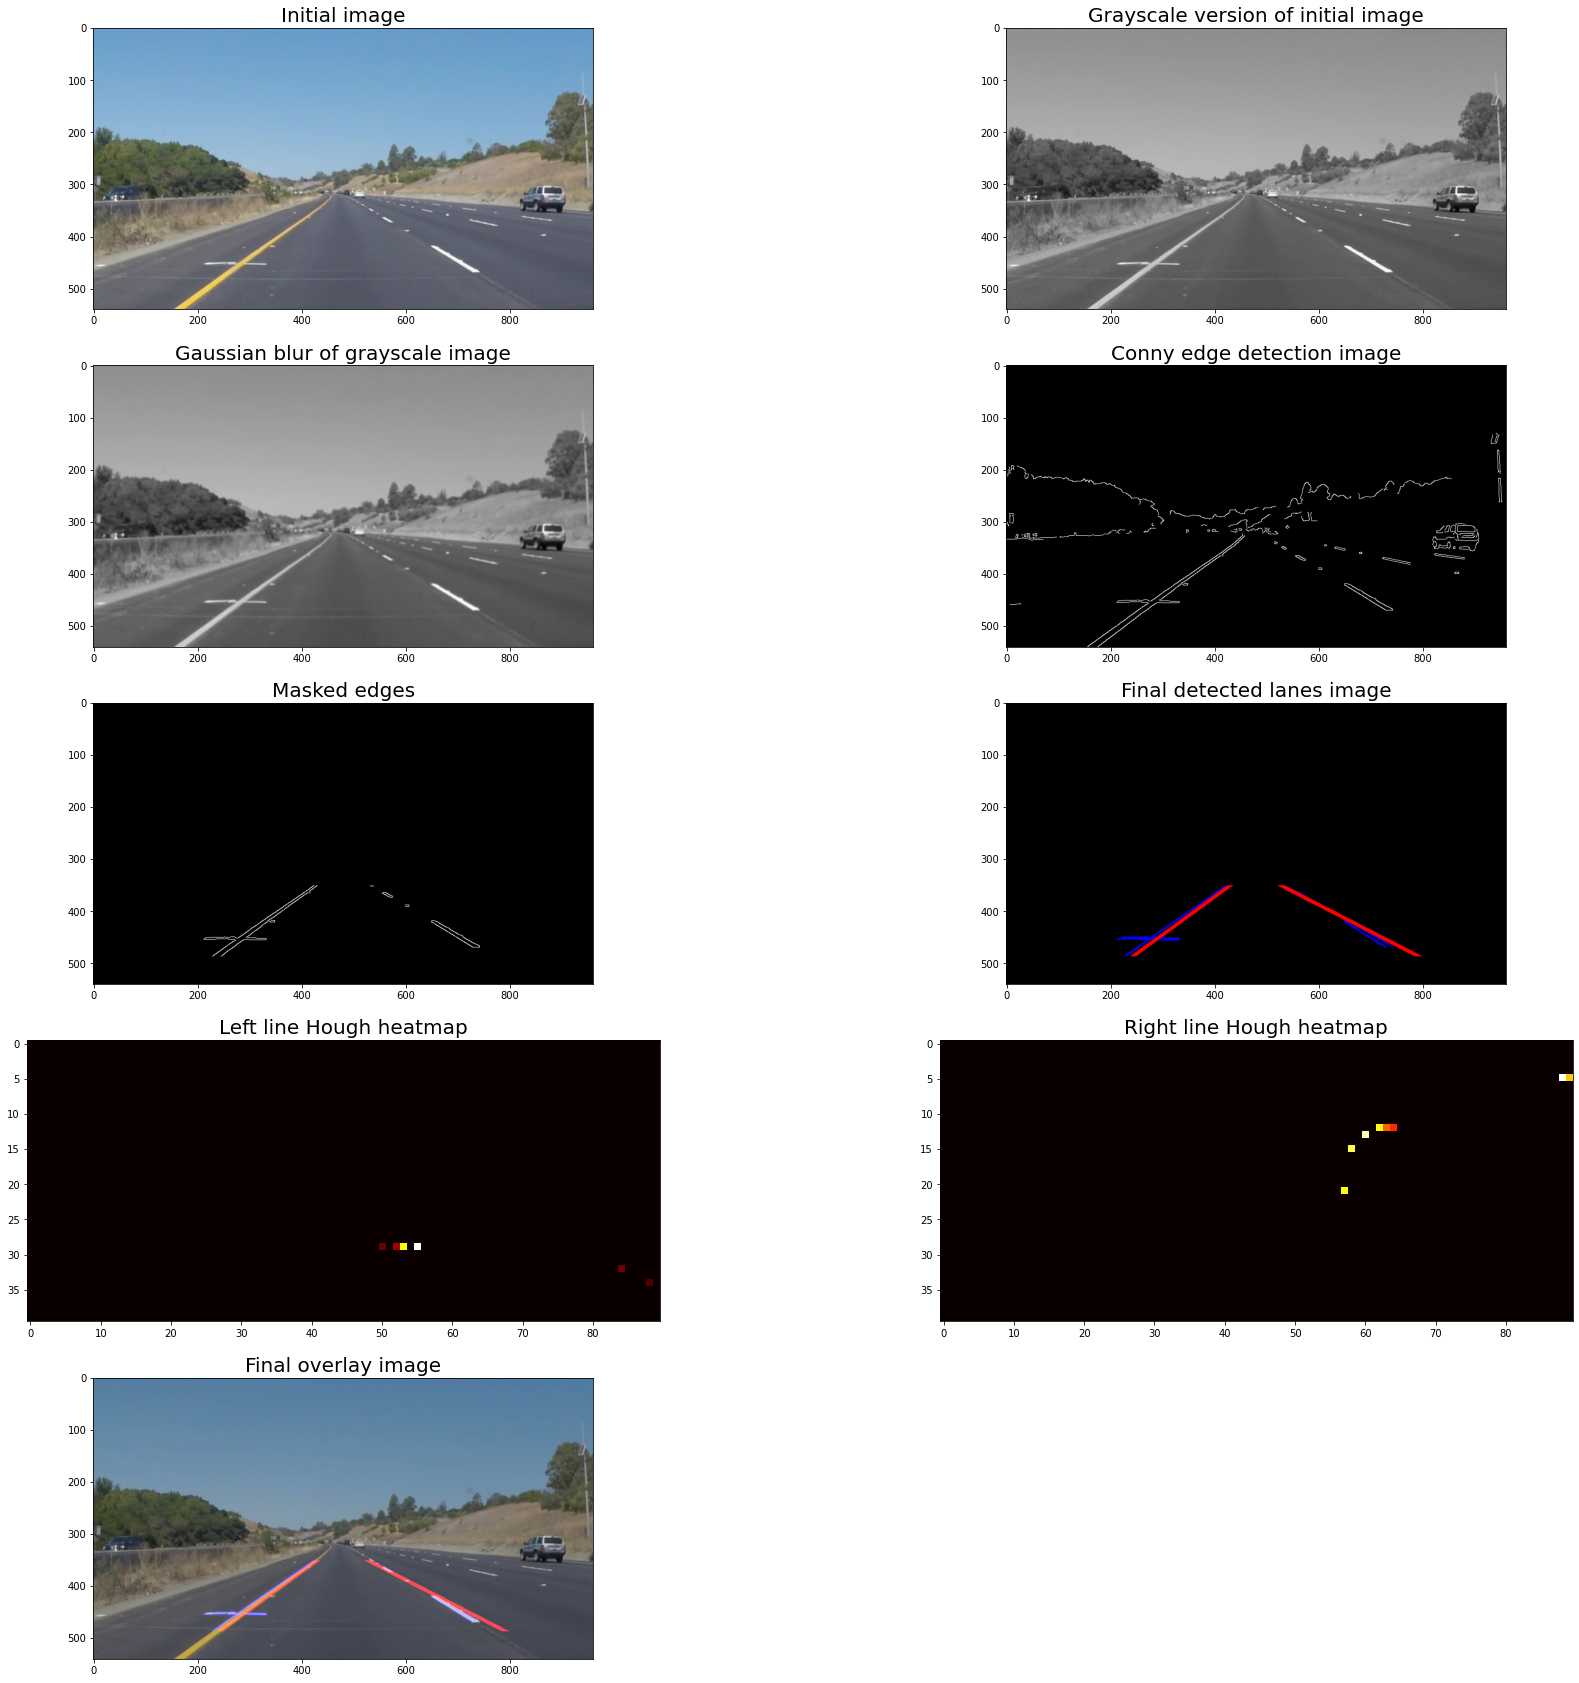

In [6]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
# Gaussian smoothing parameters
gaussian_blur_kernel_size = 5
# Canny edge detection paramaters
canny_low_threshold = 100
canny_high_threshold = 200

# Mask parameters
vertices = np.array([[(960*1/10,540*9/10), (960*4/10,540*65/100), (960*6/10,540*65/100), (960*9/10,540*9/10)]], dtype=np.int32)
#vertices = np.array([[[1280*1/10,720*9/10], [1280*4/10,720*65/100], [1280*6/10,720*65/100], [1280*9/10,720*9/10]]], dtype=np.int32)

# Hough transform parameters
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 30    # maximum gap in pixels between connectable line segments

#im_name = 'vlcsnap-2021-02-28-20h28m23s569.jpg'
#im_name = 'solidWhiteRight.jpg'
#im_name = 'vlcsnap-2021-03-14-17h14m02s670.jpg'
im_name = 'vlcsnap-2021-03-21-18h30m22s331.jpg'

init_image = mpimg.imread(f"test_images/{im_name}")
plt.rcParams['figure.figsize'] = [30, 30]

plt.subplot(521).imshow(init_image)
plt.subplot(521).set_title('Initial image', fontsize=20)
# Gayscale
gray = grayscale(init_image)
plt.subplot(522).imshow(gray, cmap='gray')
plt.subplot(522).set_title('Grayscale version of initial image', fontsize=20)
# Gaussian smoothing
smoothed_img = gaussian_blur(gray, gaussian_blur_kernel_size)
plt.subplot(523).imshow(smoothed_img, cmap='gray')
plt.subplot(523).set_title('Gaussian blur of grayscale image', fontsize=20)
# Conny edge detection
edges_img = canny(smoothed_img, canny_low_threshold, canny_high_threshold)
plt.subplot(524).imshow(edges_img, cmap='gray')
plt.subplot(524).set_title('Conny edge detection image', fontsize=20)
# Mask
masked_edges_img = region_of_interest(edges_img, vertices)
plt.subplot(525).imshow(masked_edges_img, cmap='gray')
plt.subplot(525).set_title('Masked edges', fontsize=20)
# Hough Transform
lines_img = hough_lines(masked_edges_img, rho, theta, threshold, min_line_length, max_line_gap, vertices, plot_hough_heatmap=True)
plt.subplot(526).imshow(lines_img)
plt.subplot(526).set_title('Final detected lanes image', fontsize=20)
# Overlay lines on initial image
lines_overlay_img = weighted_img(lines_img, init_image)
plt.subplot(529).imshow(lines_overlay_img)
plt.subplot(529).set_title('Final overlay image', fontsize=20)
# Save image
mpimg.imsave(f"test_images_output/{im_name}", lines_overlay_img)


 Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

 Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [7]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

for init_image_name in os.listdir("test_images/"):
    if init_image_name.startswith('.'):
        continue
    init_image = mpimg.imread(f"test_images/{init_image_name}")
    # Gayscale
    gray = grayscale(init_image)
    # Gaussian smoothing
    smoothed_img = gaussian_blur(gray, gaussian_blur_kernel_size)
    # Conny edge detection
    edges_img = canny(smoothed_img, canny_low_threshold, canny_high_threshold)
    # Mask
    masked_edges_img = region_of_interest(edges_img, vertices)
    # Hough Transform
    lines_img = hough_lines(masked_edges_img, rho, theta, threshold, min_line_length, max_line_gap, vertices)
    # Overlay lines on initial image
    lines_overlay_img = weighted_img(lines_img, init_image)
    # Save image
    mpimg.imsave(f"test_images_output/{init_image_name}", lines_overlay_img)


 ### Test on Videos

 You know what's cooler than drawing lanes over images? Drawing lanes over video!

 We can test our solution on two provided videos:

 `solidWhiteRight.mp4`

 `solidYellowLeft.mp4`

 **Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

 **If you get an error that looks like this:**
 ```
 NeedDownloadError: Need ffmpeg exe.
 You can download it by calling:
 imageio.plugins.ffmpeg.download()
 ```
 **Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML



In [9]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image where lines are drawn on lanes)

    # Gayscale
    gray = grayscale(image)
    # Gaussian smoothing
    smoothed_img = gaussian_blur(gray, gaussian_blur_kernel_size)
    # Conny edge detection
    edges_img = canny(smoothed_img, canny_low_threshold, canny_high_threshold)
    # Mask
    masked_edges_img = region_of_interest(edges_img, vertices)
    # Hough Transform
    lines_img = hough_lines(masked_edges_img, rho, theta, threshold, min_line_length, max_line_gap, vertices)
    # Overlay lines on initial image
    result = weighted_img(lines_img, image)

    return result


 Let's try the one with the solid white lane on the right first ...

In [10]:
vertices = np.array([[(960*1/10,540), (960*4/10,540*65/100), (960*6/10,540*65/100), (960*9/10,540)]], dtype=np.int32)
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
get_ipython().run_line_magic('time', 'white_clip.write_videofile(white_output, audio=False)')


t:   5%|▍         | 11/221 [00:00<00:02, 102.85it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 1.81 s, sys: 504 ms, total: 2.31 s
Wall time: 2.18 s


 Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))


 ## Improve the draw_lines() function

 **At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

 **Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

 // TODO We could use the resulting lines in the previous video images to better compute the lines in the current image by excluding the input lines where the m coefficient is too different from the resulting lines in the previous pictures. That would also smoothen the rendering of the resulting lines on the video. However, since the resulting lines will be used as input to the steering wheel we might not want to smoothen too much to keep a good responsiveness of the vehicle.

 In the draw_lines() function we divide by the difference (x2-x1) to get m.
 For at least one image, that difference was 0 leading to exceptions. I decided to use polar coordinates to compute the average lines instead.
 I didn't manage to get proper lines with polar coordinates, so I decided to return to cartesian coordinates.
 I switched y and x in the computation of the average lines, and skip the processing of horizontal lines.

 Now for the one with the solid yellow lane on the left. This one's more tricky!

In [12]:
vertices = np.array([[(960*1/10,540), (960*4/10,540*65/100), (960*6/10,540*65/100), (960*9/10,540)]], dtype=np.int32)
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
get_ipython().run_line_magic('time', 'yellow_clip.write_videofile(yellow_output, audio=False)')



t:   2%|▏         | 12/681 [00:00<00:05, 115.74it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 5.64 s, sys: 1.47 s, total: 7.11 s
Wall time: 5.87 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))


 ## Writeup and Submission

 If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


 ## Optional Challenge

 Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!
 TODO Find a way to only keep groups of lines parallel to each other. Those define the lanes.

In [14]:
vertices = np.array([[[1280*1/10,720*9/10], [1280*4/10,720*65/100], [1280*6/10,720*65/100], [1280*9/10,720*9/10]]], dtype=np.int32)
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
get_ipython().run_line_magic('time', 'challenge_clip.write_videofile(challenge_output, audio=False)')



t:   3%|▎         | 7/251 [00:00<00:03, 61.61it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 3.85 s, sys: 1.27 s, total: 5.13 s
Wall time: 4.97 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))


